In [2]:
from dataset.datasets import get_dataset
from torch_geometric.datasets import WebKB, Planetoid, KarateClub, Airports
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.utils import is_undirected, get_laplacian, to_undirected, to_dense_adj
import torch

In [3]:
def get_lap(dataset):
    data = dataset[0]
    edge_index = to_undirected((data.edge_index))
    assert is_undirected(edge_index)

    lap = get_laplacian(edge_index, normalization="sym")
    lap = to_dense_adj(lap[0], edge_attr=lap[1])
    return data, lap

In [4]:
def eigen_decompose(lap):
    e, v = torch.linalg.eigh(lap)
    e = e.squeeze()
    v = v.squeeze()
    return e, v

In [5]:
def find_eigen_representaion(v, y):
    best_dist = float('inf')
    best_i = 0
    best_j = 0
    y= y.long()
    num_classes = y.max() + 1
    for i in range(1, v.shape[0]):
        for j in range(1, v.shape[0]):
            if i == j:
                continue
            embed = v[:, [i, j]]
            dist_1 = []
            dist_2 = [0.]
            for c in range(num_classes):
                if (y == c).count_nonzero() > 1:
                    dist_1.append(torch.pdist(embed[y == c]).mean())
                    for d in range(num_classes):
                        if c != d:
                            dist_2.append(torch.cdist(embed[y == c], embed[y == d]).mean()/num_classes)
            dist = torch.tensor(dist_1).mean() - torch.tensor(dist_2).mean()

            if best_dist > dist:
                best_dist = dist
                print(i, j)
                best_i = i
                best_j = j
    return best_i, best_j

In [6]:
def plot_data_points(i, j, y):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(projection='3d')
    ax = v[:,i]
    ay = v[:,j]
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    plt.scatter(ax, ay, s=50, c=[colours[c] for c in y.long().tolist()])
    plt.show()

In [7]:
name = 'Wisconsin'
path = osp.join('..', 'data', name)
dataset = WebKB(path, name)
data, lap = get_lap(dataset)

In [8]:
name = 'Europe'
path = osp.join('..', 'data', name)
dataset = Airports(path, name)
data, lap = get_lap(dataset)

In [9]:
e, v = eigen_decompose(lap)

In [268]:
e[[4, 7]]

tensor([0.3631, 0.4794])

In [269]:
i, j = find_eigen_representaion(v, data.y)

1 2
1 3
1 5
1 366
3 366
3 382
208 366
208 382
366 382


In [270]:
print(i, j)

366 382


<Figure size 432x288 with 0 Axes>

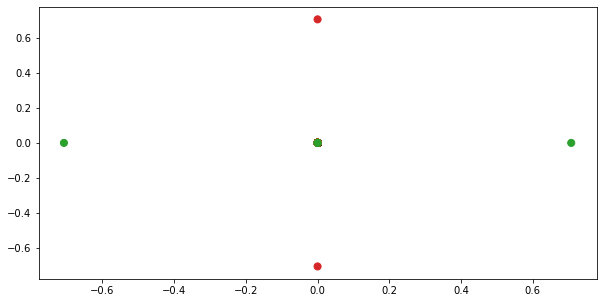

In [271]:
plot_data_points(i, j, data.y)

<Figure size 432x288 with 0 Axes>

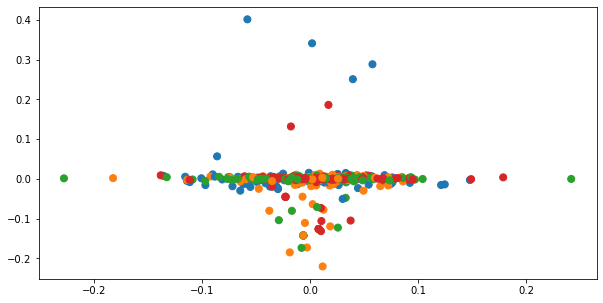

In [272]:
plot_data_points(data.num_nodes-36, data.num_nodes - 1, data.y)

In [10]:
name = 'Europe'
path = osp.join('..', 'data', name)
dataset = Airports(path, name)
data, lap = get_lap(dataset)

In [145]:
e, v = eigen_decompose(lap)

In [146]:
i, j = find_eigen_representaion(v, data.y)

1 2
1 3
1 5
1 366
3 366
3 382
208 366
208 382
366 382


<Figure size 432x288 with 0 Axes>

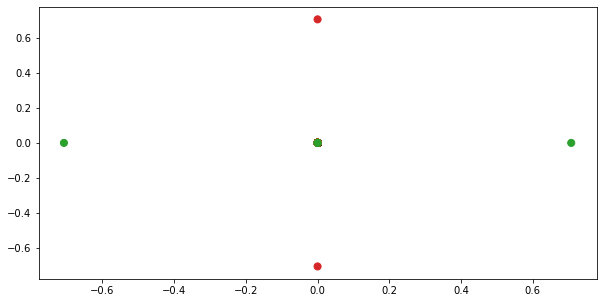

In [273]:
plot_data_points(i, j, data.y)

<Figure size 432x288 with 0 Axes>

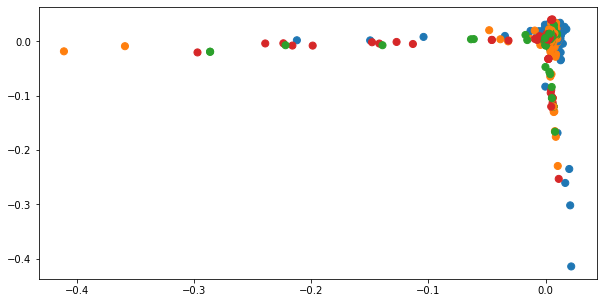

In [274]:
plot_data_points(1, 2, data.y)

In [275]:
i

366

In [276]:
j

382

In [277]:
data.y.shape

torch.Size([399])

using cpu
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/251 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


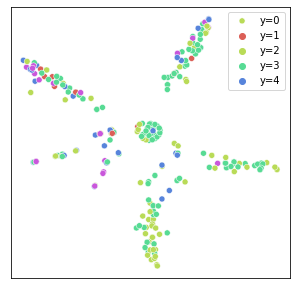

In [258]:
x = v[:, [248,   0, 250, 243,   3, 220,   8,  71,   6, 164,   7, 241, 249, 247,
        ]]
x = v[:, [0, 1, 2, 3, 4, 5]]
# indices=tensor([ 37,  93, 159, 192,  88, 184,  83,  17, 175,  50]))

from tsne_torch import TorchTSNE as TSNE
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
ax= sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=res,
    legend="full",
    # alpha=0.3
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.legend(labels=["y=0","y=1","y=2","y=3", "y=4"])
plt.savefig('sc_low.eps', format='eps')

using cpu
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/399 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


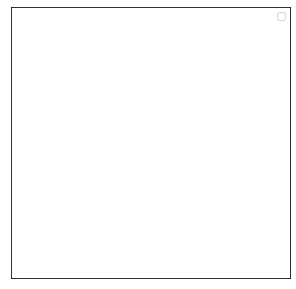

In [291]:
weight = torch.load('../models/saved_models/node_classification/europe_supervised_struct.pt')['model']['W']
x = v.mm(weight)
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=res,
    legend="full",
    # alpha=0.3
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.legend(labels=["y=0","y=1","y=2","y=3", "y=4"])
plt.savefig('sc_learn.eps', format='eps')


In [294]:
x.shape

torch.Size([399, 32])

In [ ]:
x = torch.load('../models/wisconsin_slice_emb.pt')
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=res,
    legend="full",
    # alpha=0.3
)

using cpu
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/399 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


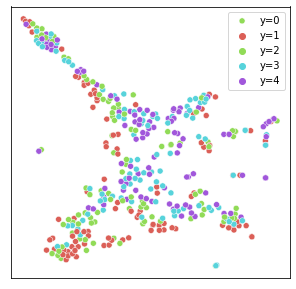

In [44]:
x = v[:, [1, 2, 3, 4, 5]]
# indices=tensor([ 37,  93, 159, 192,  88, 184,  83,  17, 175,  50]))

from tsne_torch import TorchTSNE as TSNE
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
ax= sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=res,
    legend="full",
    # alpha=0.3
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.legend(labels=["y=0","y=1","y=2","y=3", "y=4"])
plt.savefig('sc_low_europe.eps', format='eps')

using cpu
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/399 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


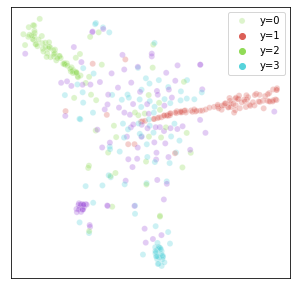

In [43]:
weight = torch.load('../models/saved_models/node_classification/europe_kmeans_struct.pt')['model']['W']
x = v.mm(weight).float()
from tsne_torch import TorchTSNE as TSNE
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

# import numpy as np
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, learning_rate='auto', verbose=True,
#                   init='random').fit_transform(x)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=res,
    legend="full",
    alpha=0.3
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.legend(labels=["y=0","y=1","y=2","y=3"])
plt.savefig('sc_learn_europe.eps', format='eps')

In [37]:
weight.abs().mean(1).topk(10)

torch.return_types.topk(
values=tensor([1.7540, 1.6837, 1.6027, 1.5123, 1.4967, 1.4916, 1.4846, 1.4659, 1.4271,
        1.4031]),
indices=tensor([386,   0, 390, 393, 389, 384, 381,  12, 192, 379]))

using cpu
initializing...
computing p-values...


  0%|          | 0/251 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

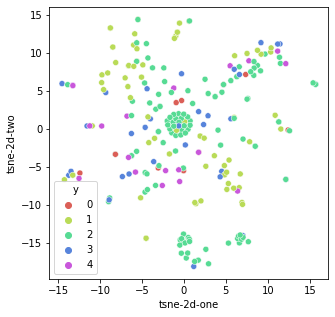

In [260]:
x = torch.load('../models/wisconsin_slice_emb.pt')
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(x)  # returns shape (n_samples, 2)

import seaborn as sns
from matplotlib import pyplot as plt
res = {}
res['y'] = data.y
res['tsne-2d-one'] = X_emb[:,0]
res['tsne-2d-two'] = X_emb[:,1]
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=res,
    legend="full",
    # alpha=0.3
)

In [221]:
weight.mean(1).topk(10)

torch.return_types.topk(
values=tensor([0.0277, 0.0253, 0.0235, 0.0213, 0.0213, 0.0206, 0.0198, 0.0193, 0.0188,
        0.0187], grad_fn=<TopkBackward0>),
indices=tensor([ 37,  93, 159, 192,  88, 184,  83,  17, 175,  50]))